#1. 흐름 이해

##1.1 전체 흐름

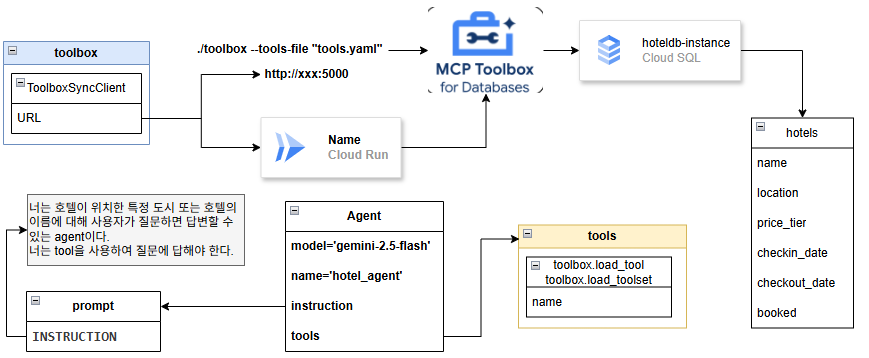

##1.2 yaml 분석

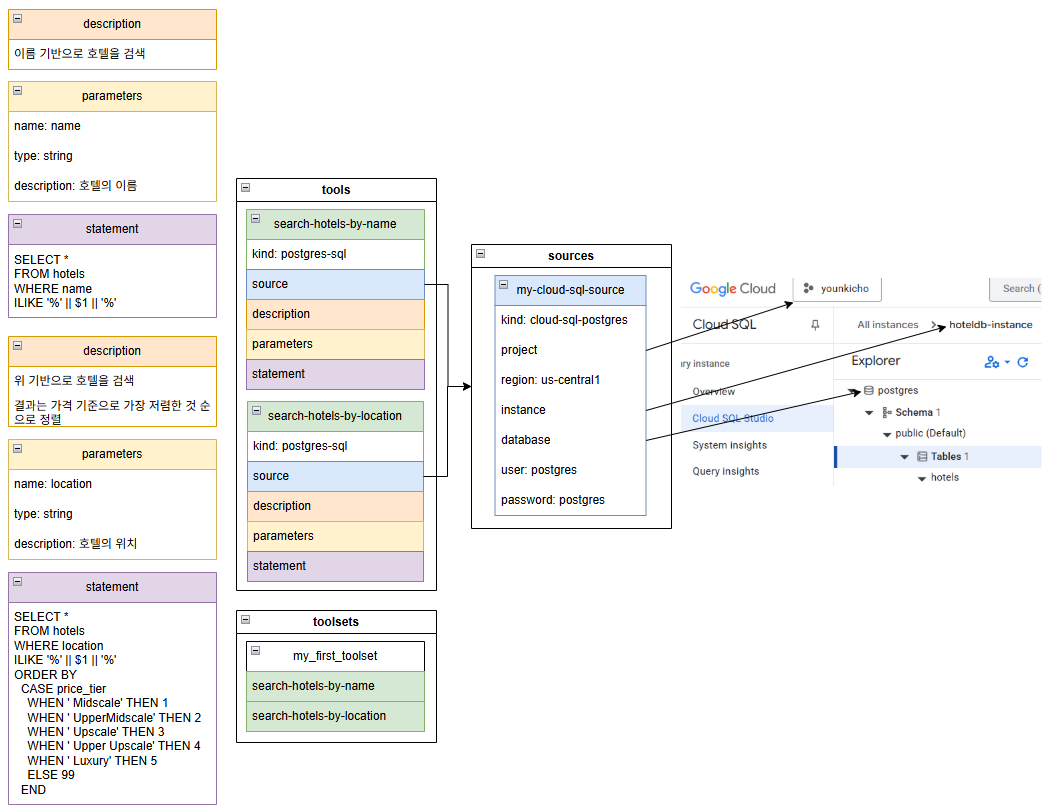

##1.3 cloud run

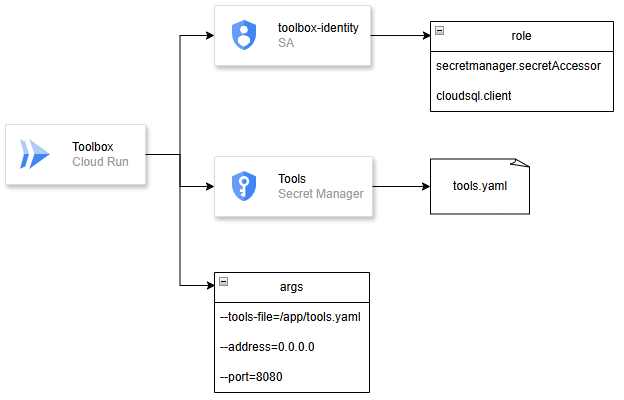

#2. 데이터 베이스 구축

## 2.1 인스턴스 생성

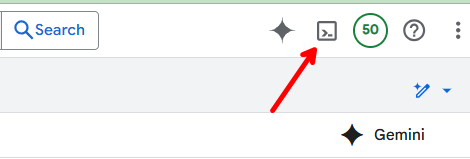

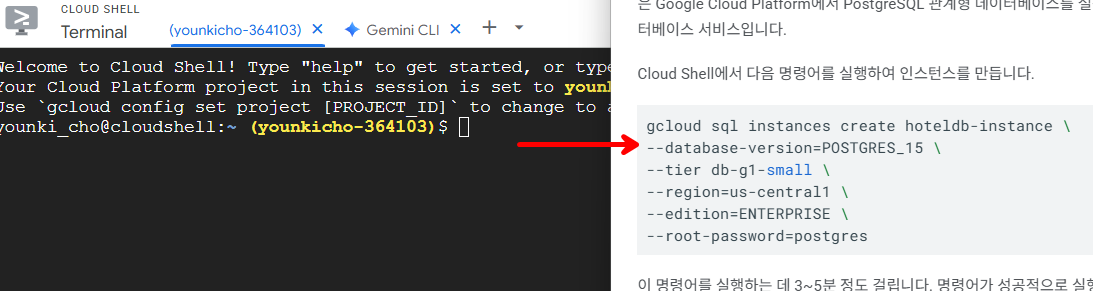

## 2.2 table 생성 및 데이터 입력

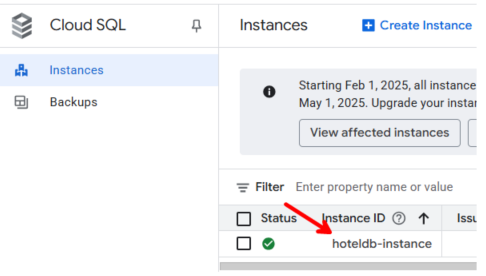

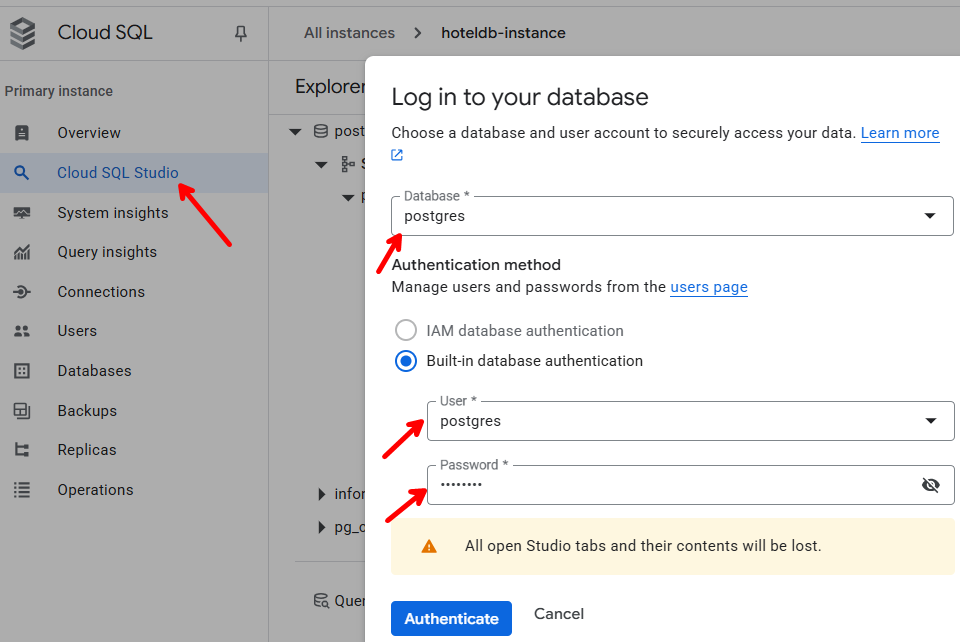

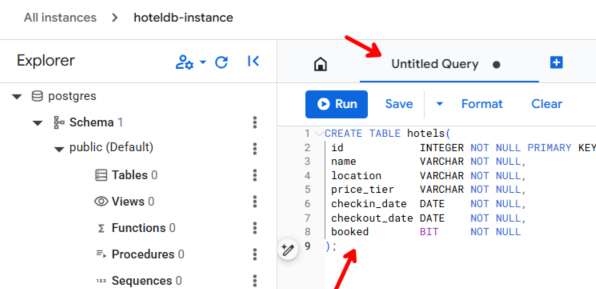

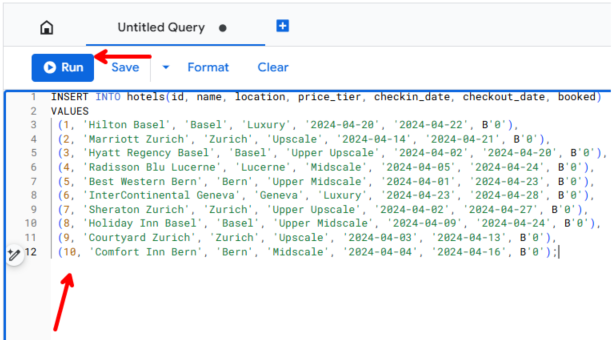

## 2.3 결과 확인

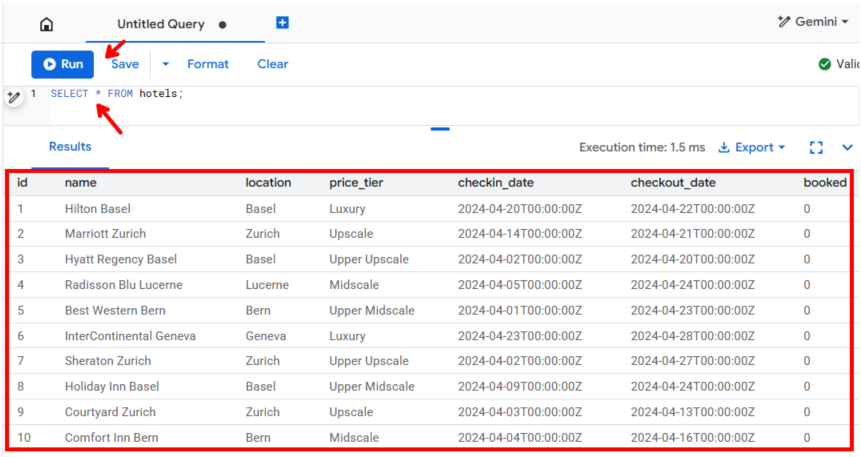

#3. MCP server 구축

## 3.1 MCP Toolbox for Databases 이해

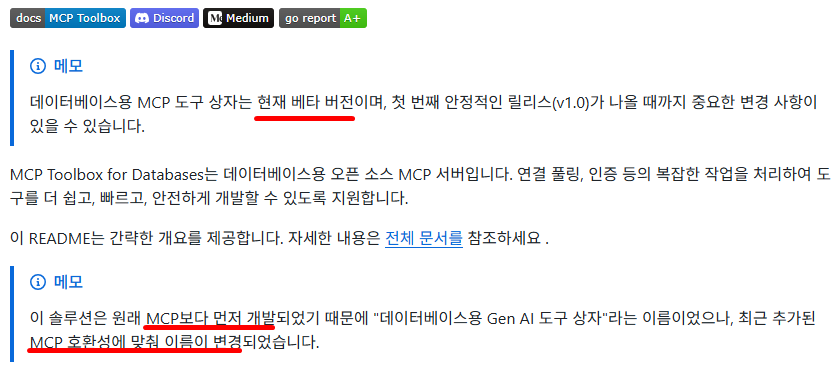

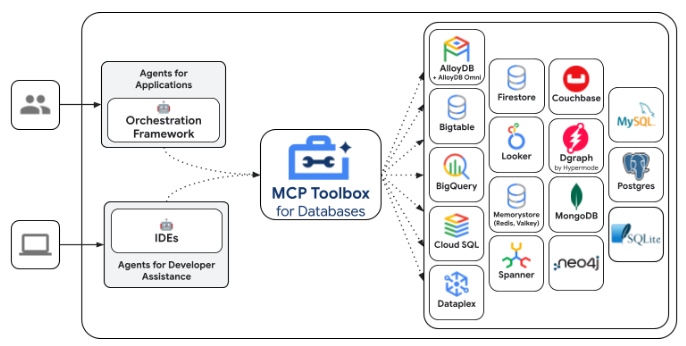

## 3.2 Toolbox 설치



```
mkdir mcp-toolbox
cd mcp-toolbox
```





```
export VERSION=0.14.0
curl -O https://storage.googleapis.com/genai-toolbox/v$VERSION/linux/amd64/toolbox
chmod +x toolbox
```



##3.3 tools.yaml 구성



```
nano tools.yaml
```





```
sources:
  my-cloud-sql-source:
    kind: cloud-sql-postgres
    project: YOUR_PROJECT_ID
    region: us-central1
    instance: hoteldb-instance
    database: postgres
    user: postgres
    password: "postgres"

tools:
  search-hotels-by-name:
    kind: postgres-sql
    source: my-cloud-sql-source
    description: Search for hotels based on name.
    parameters:
      - name: name
        type: string
        description: The name of the hotel.
    statement: SELECT * FROM hotels WHERE name ILIKE '%' || $1 || '%';
  search-hotels-by-location:
    kind: postgres-sql
    source: my-cloud-sql-source
    description: Search for hotels based on location.  Result is sorted by price from least to most expensive.
    parameters:
      - name: location
        type: string
        description: The location of the hotel.
    statement: |
      SELECT *
      FROM hotels
      WHERE location ILIKE '%' || $1 || '%'
      ORDER BY
        CASE price_tier
          WHEN 'Midscale' THEN 1
          WHEN 'Upper Midscale' THEN 2
          WHEN 'Upscale' THEN 3
          WHEN 'Upper Upscale' THEN 4
          WHEN 'Luxury' THEN 5
          ELSE 99 -- Handle any unexpected values, place them at the end
        END;

toolsets:
   my_first_toolset:
     - search-hotels-by-name
     - search-hotels-by-location
```



##3.4 server 실행



```
./toolbox --tools-file "tools.yaml"
```



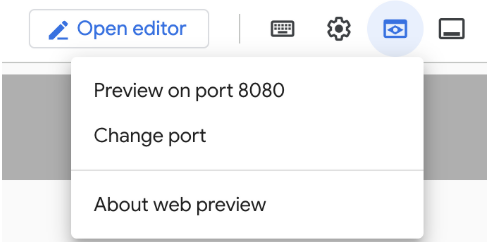

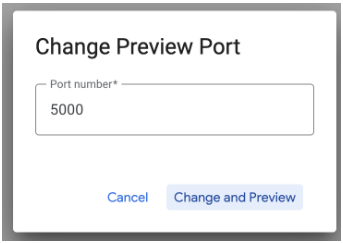

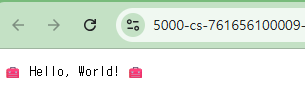

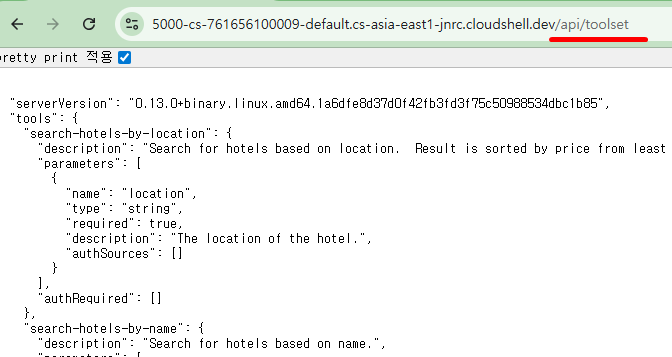

## 3.5 server 실행 - ui



```
./toolbox --tools-file "tools.yaml" --ui
```



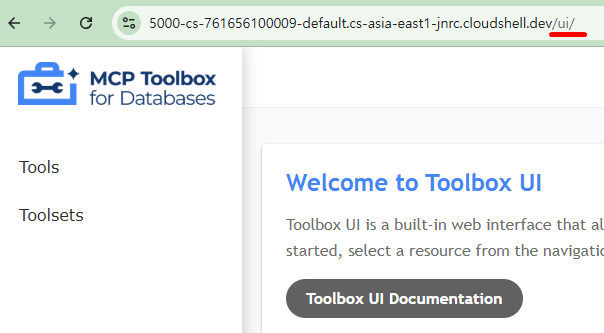

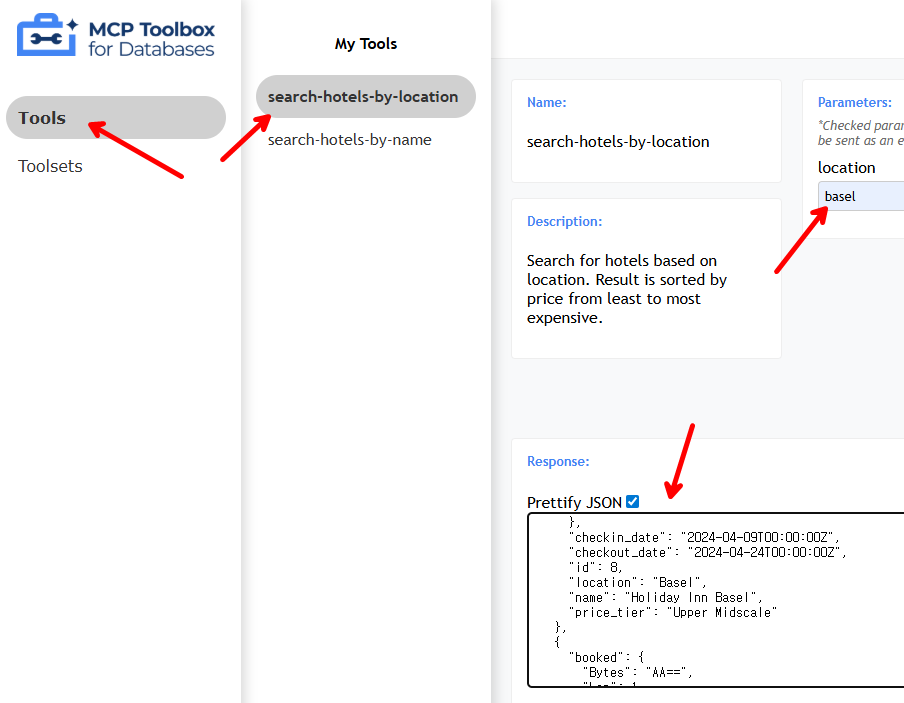

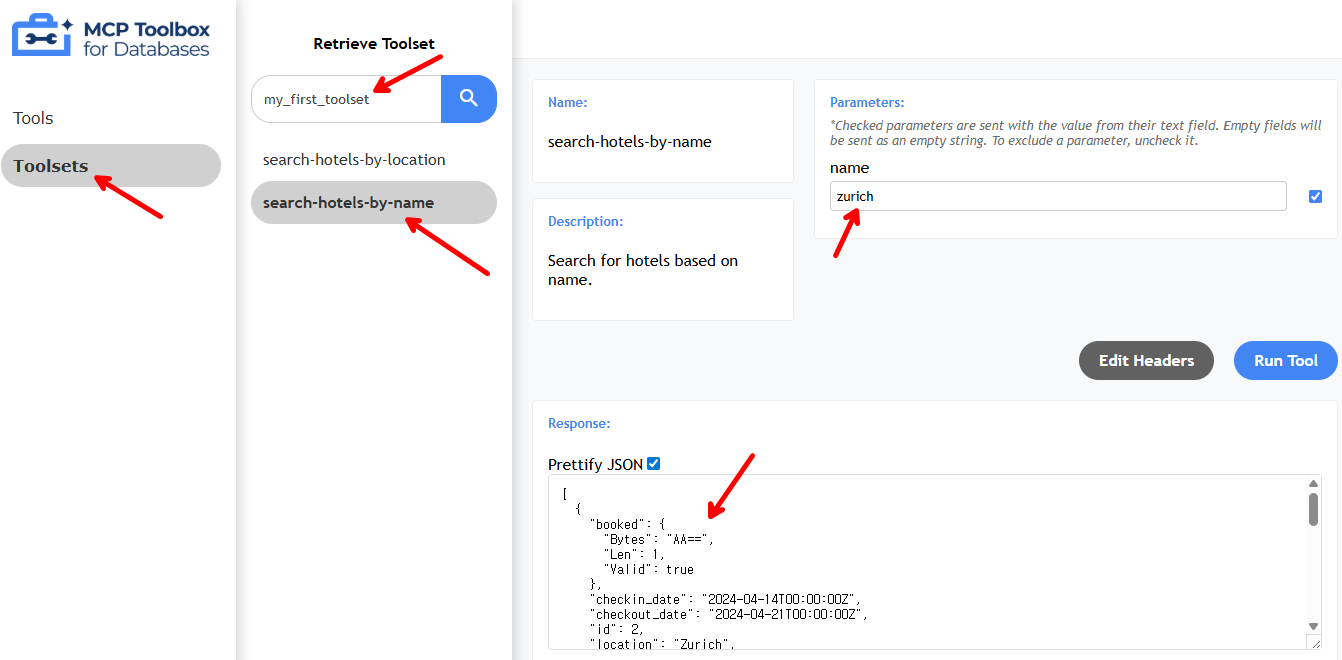

#4. agent 생성

#4.1 환경 설정



```
cd ~
mkdir my-agents
cd my-agents
```





```
python -m venv .myenv
source .myenv/bin/activate
```





```
pip install google-adk toolbox-core
```





```
adk create hotel-agent-app
```



Choose a model for the root agent: 1
1. gemini-2.5-flash
2. Other models (fill later)

Choose model (1, 2): 1
1. Google AI
2. Vertex AI

Choose a backend (1, 2): 2

You need an existing Google Cloud account and project, check out this link for details:
https://google.github.io/adk-docs/get-started/quickstart/#gemini---google-cloud-vertex-ai

Enter Google Cloud project ID [younkicho-364103]:

Enter Google Cloud region [us-central1]:

Agent created in /home/younki_cho/my-agents/hotel-agent-app:
- .env
- __init__.py
- agent.py

##4.2 code

###4.2.1 agent.py

In [ ]:
# agent.py

from google.adk.agents import Agent
from toolbox_core import ToolboxSyncClient
from . import prompt
toolbox = ToolboxSyncClient("http://127.0.0.1:5000")

# Load single tool
# tools = toolbox.load_tool('search-hotels-by-location')

# Load all the tools
tools = toolbox.load_toolset('my_first_toolset')

root_agent = Agent(
    name="hotel_agent",
    model="gemini-2.5-flash",
    instruction=prompt.INSTRUCTION,
    tools=tools,
)

###4.2.2 prompt.py

In [ ]:
# prompt.py

INSTRUCTION="""
너는 호텔이 위치한 특정 도시 또는 호텔의 이름에 대해 사용자가 질문하면 답변할 수 있는 agent이다.
너는 tool을 사용하여 질문에 답해야 한다.
"""

##4.3 실행

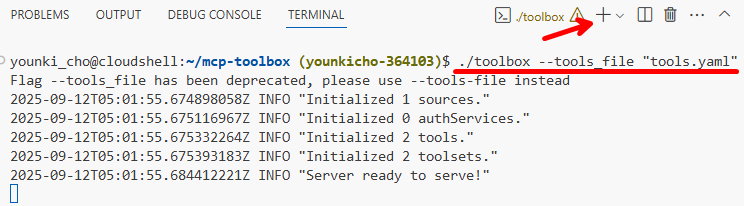

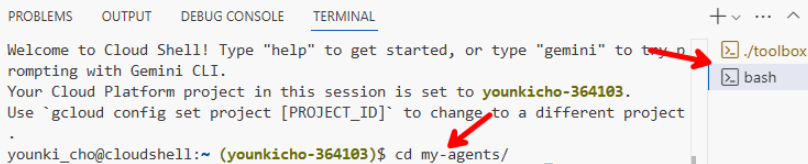

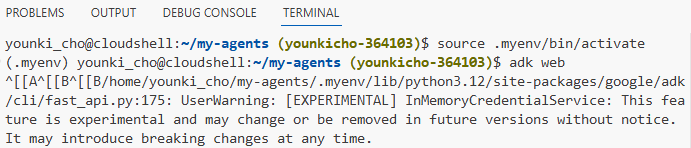

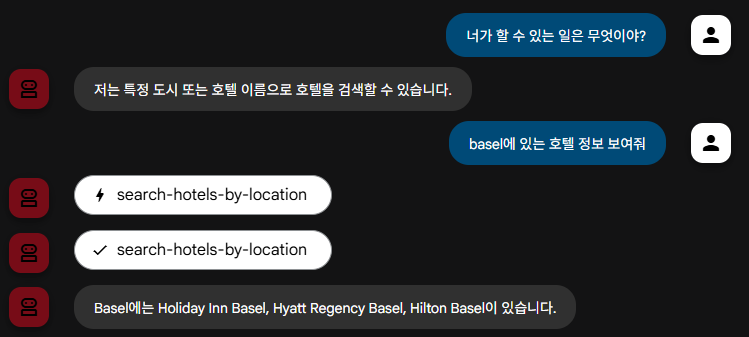

#5. Cloud run 연동

##5.1 api 활성화



```
export PROJECT_ID="YOUR_GOOGLE_CLOUD_PROJECT_ID"

gcloud services enable run.googleapis.com \
                       cloudbuild.googleapis.com \
                       artifactregistry.googleapis.com \
                       iam.googleapis.com \
                       secretmanager.googleapis.com
```



##5.2 Service Account 생성



```
gcloud iam service-accounts create toolbox-identity

gcloud projects add-iam-policy-binding $PROJECT_ID \
   --member serviceAccount:toolbox-identity@$PROJECT_ID.iam.gserviceaccount.com \
   --role roles/secretmanager.secretAccessor

gcloud projects add-iam-policy-binding $PROJECT_ID \
   --member serviceAccount:toolbox-identity@$PROJECT_ID.iam.gserviceaccount.com \
   --role roles/cloudsql.client
```



##5.3 file 암호화



```
gcloud secrets create tools --data-file=tools.yaml
```



##5.4 MCP server cloud run 배포



```
export IMAGE=us-central1-docker.pkg.dev/database-toolbox/toolbox/toolbox:latest

gcloud run deploy toolbox \
--image $IMAGE \
--service-account toolbox-identity \
--region us-central1 \
--set-secrets "/app/tools.yaml=tools:latest" \
--args="--tools_file=/app/tools.yaml","--address=0.0.0.0","--port=8080" \
--allow-unauthenticated
```



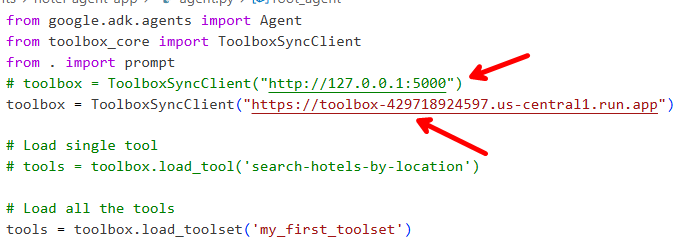

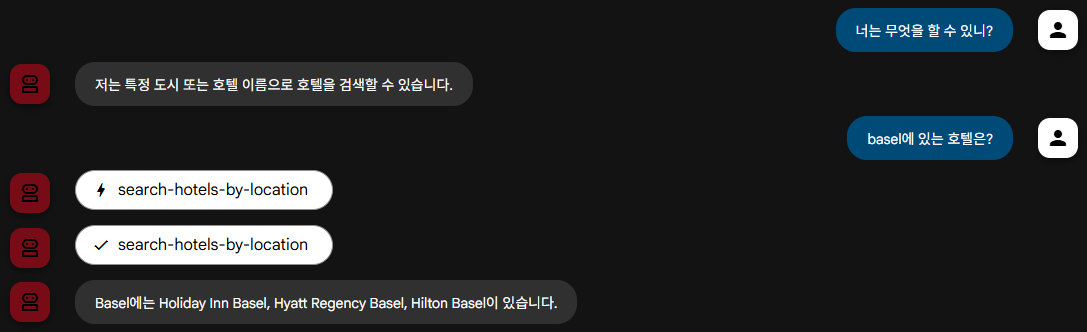

## 5.5 app cloud run 배포

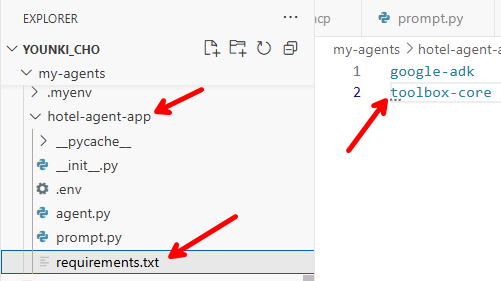



```
export GOOGLE_CLOUD_PROJECT=YOUR_GOOGLE_CLOUD_PROJECT_ID
export GOOGLE_CLOUD_LOCATION=us-central1
export AGENT_PATH="hotel-agent-app/"
export SERVICE_NAME="hotels-service"
export APP_NAME="hotels-app"
export GOOGLE_GENAI_USE_VERTEXAI=True
```





```
adk deploy cloud_run \
--project=$GOOGLE_CLOUD_PROJECT \
--region=$GOOGLE_CLOUD_LOCATION \
--service_name=$SERVICE_NAME  \
--app_name=$APP_NAME \
--with_ui \
$AGENT_PATH
```



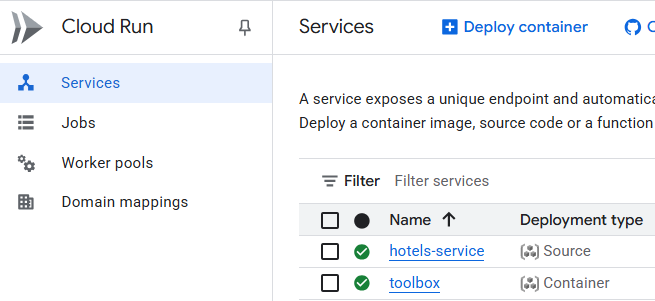

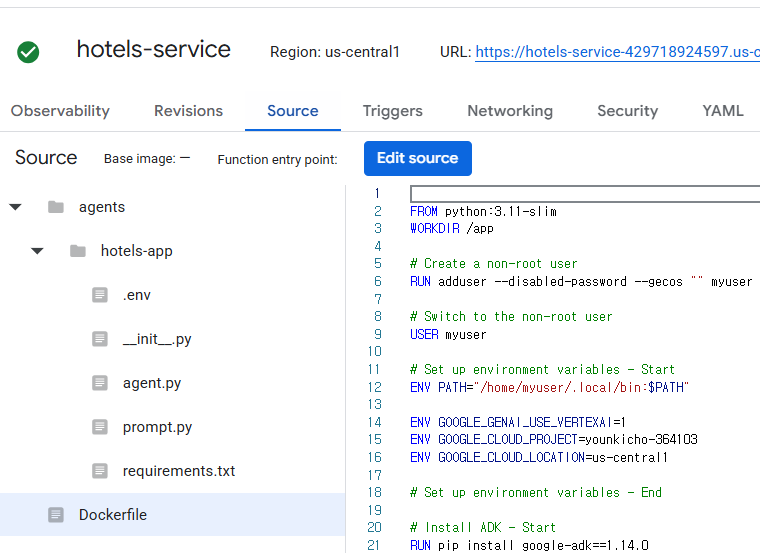

#6. 삭제

##6.1 환경변수 설정



```
export PROJECT_ID="YOUR_PROJECT_ID"
export REGION="YOUR_REGION"
```



## 6.2 cloud run



```
gcloud run services delete toolbox --platform=managed --region=${REGION} --project=${PROJECT_ID} --quiet
gcloud run services delete hotels-service --platform=managed --region=${REGION} --project=${PROJECT_ID} --quiet
```



##6.3 Cloud SQL



```
gcloud sql instances delete hoteldb-instance
```



##6.4 Secret Manager



```
gcloud secrets delete tools
```



## 6.5 SA



```
gcloud iam service-accounts delete toolbox-identity@$PROJECT_ID.iam.gserviceaccount.com
```



## 6.6 API disable



```
gcloud services disable run.googleapis.com \
                       cloudbuild.googleapis.com \
                       artifactregistry.googleapis.com \
                       iam.googleapis.com \
                       secretmanager.googleapis.com
```





```
gcloud services disable cloudresourcemanager.googleapis.com \
                       servicenetworking.googleapis.com \
                       run.googleapis.com \
                       cloudbuild.googleapis.com \
                       cloudfunctions.googleapis.com \
                       aiplatform.googleapis.com \
                       sqladmin.googleapis.com \
                       compute.googleapis.com
```



##6.7 code 삭제



```
cd ~
rm -rf mcp-toolbox
rm -rf my-agents
```



#7. 참조

- https://codelabs.developers.google.com/travel-agent-mcp-toolbox-adk?hl=ko#0
- https://googleapis.github.io/genai-toolbox/resources/sources/
- https://github.com/googleapis/genai-toolbox